In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas, re

data = pandas.read_csv("/content/drive/Othercomputers/내 노트북/File/spamVenv/files/spam.csv", encoding="UTF-8").dropna(axis=0)

originData = data[["Subject", "Spam/Ham"]].rename(columns={"Spam/Ham":"isSpam", "Subject":"content"}).drop_duplicates() #제목, 스팸여부 & 중복제거(결측치)
originData["isSpam"] = originData['isSpam'].replace(["ham", "spam"], [0, 1]) #범주형 -> 수치형
# data["isSpam"].value_counts() #스팸 비율
# print(f'스팸 : 정상 비율 : {data["isSpam"].value_counts()[0]/data["isSpam"].size} : {data["isSpam"].value_counts()[1]/data["isSpam"].size}')

_index = originData['content'].apply(lambda x: isinstance(x, (int, float))).index[originData['content'].apply(lambda x: isinstance(x, (int, float)))]
originData = originData.drop(_index)
originData['content'].apply(lambda x: isinstance(x, (int, float))).sum()

originData

,content,isSpam
1,"vastar resources , inc .",0
2,calpine daily gas nomination,0
3,re : issue,0
4,meter 7268 nov allocation,0
5,mcmullen gas for 11 / 99,0
...,...,...
33706,= ? iso - 8859 - 2 ? q ? my _ proposition ? =,1
33707,make big bucks in the medical field bait - exc...,1
33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,1
33712,all prescript medicines are on special . to be...,1


In [ ]:
from sklearn.model_selection import train_test_split

datas = []
for i in range(5, 100, 5):
    dataRatio  = round(i/100,2)
    _, Xdata, _, Ydata = train_test_split(originData["content"], originData["isSpam"], test_size=dataRatio, random_state=123, stratify=originData["isSpam"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=123, stratify=Ydata) #훈련데이터, 테스트데이터 나누기 (비율 8:2, 시드값 123?)
    datas.append({"ratio":dataRatio, "Xdata":Xdata , "Xtrain":Xtrain, "Xtest":Xtest, "Ytrain":Ytrain, "Ytest":Ytest})




In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import mean
for index, data in enumerate(datas):
    Xdata = data["Xdata"]
    Xtrain = data["Xtrain"]
    Xtest = data["Xtest"]
    tokenizer = Tokenizer() #토큰화 진행
    tokenizer.fit_on_texts(Xdata) #각 단어를 숫자와 매핑시키는 집합 생성

    meanLen = round(mean([len(i) for i in Xdata])) #문장의 길이를 통일하기 위해 문장의 길이 평균값

    encodedXtrain = tokenizer.texts_to_sequences(Xtrain) #각 문장의 단어들을 위 집합을 기반으로 [abc, cba] -> [3,39] 와 같이 변경 : encoding된 느낌
    finalXtrain = pad_sequences(encodedXtrain, maxlen=meanLen, padding='post') #입력 데이터 최종본 : 위에서 숫자로 이루어진 문장을 모두 같은 길이의 문장으로 만들어줌(0으로 채워넣는 pad sequence)

    encodedXtest = tokenizer.texts_to_sequences(Xtest)
    finalXtest = pad_sequences(encodedXtest, maxlen=meanLen, padding='post')

    datas[index]["Xtrain"] = finalXtrain
    datas[index]["Xtest"] = finalXtest
    datas[index]["tokenizer"] = tokenizer
    datas[index]["meanLen"] = meanLen
# Xtrain.iloc[0], encodedXtrain[0], finalXtrain[0], print(f'문장의 길이 평균값 : {meanLen}')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, SimpleRNN
for index, data in enumerate(datas):
    tokenizer = data["tokenizer"]
    meanLen = data["meanLen"]
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 32)) #Embedding(단어 집합 길이 + 1, 출력 차원, 입력 최대 길이) -> 입력층
    model.add(SimpleRNN(32))
    # model.add(Flatten()) #다차원을 1차원으로 바꾸어 Dense에 들어갈 수 있도록 변환
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid")) #sigmoid함수를 활성화 함수로 하는 Dense, 출력 1개 -> 출력층
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    datas[index]["model"] = model


In [ ]:
import time
for index, data in enumerate(datas):
    model = data["model"]
    Xtrain = data["Xtrain"]
    Ytrain = data["Ytrain"]
    startTime = time.time()
    model.fit(Xtrain, Ytrain, epochs=1, batch_size=100) # 전체 데이터를 2번, 32개씩 풀고 채점
    endTime = time.time()
    datas[index]["time"] = endTime - startTime
# print(f'걸린 시간 : {endTime - startTime}초')

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4814 - loss: 0.7012
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5374 - loss: 0.6853
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5952 - loss: 0.6631
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6039 - loss: 0.6544
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5777 - loss: 0.6601
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6290 - loss: 0.6365
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6127 - loss: 0.6325
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6757 - loss: 0.5763
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6306 - loss: 0.6103
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7058 - loss: 0.5490
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6948 - loss: 0.5630
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6692 - loss: 0.5876
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6398 - loss: 0.6138
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [ ]:
#모델을 평가하기 위해 test데이터를 전처리 하는 과정(encoding, pad ...)
results = []
for index, data in enumerate(datas):
    model = data["model"]
    Xtest = data["Xtest"]
    Ytest = data["Ytest"]
    loss, accuracy = model.evaluate(Xtest, Ytest, batch_size = 100)
    datas[index]["loss"] = loss
    datas[index]["accuracy"] = accuracy
    results.append({"ratio":data["ratio"], "loss":loss, "accuracy":accuracy, "time":data["time"]})
# print(f'정확도 : {accuracy*100}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5393 - loss: 0.6891  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6304 - loss: 0.6338  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7507 - loss: 0.5239  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7819 - loss: 0.4972
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8080 - loss: 0.4669
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8101 - loss: 0.4318
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8230 - loss: 0.4116
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8756 - loss: 0.3196
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8503 - loss: 0.3470
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8747 - loss: 0.3094
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8799 - loss: 0.3094
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.3466
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8121 - loss: 0.4224
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

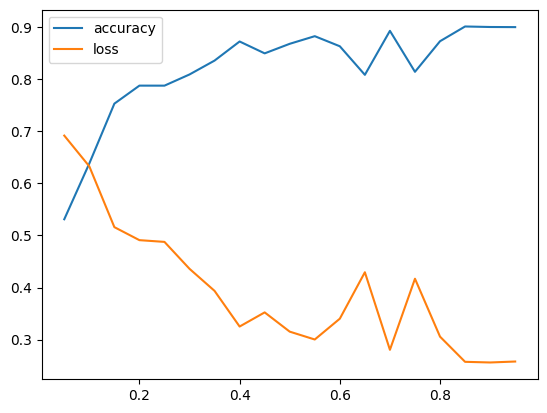

In [ ]:
import matplotlib.pyplot as plt

x = [data["ratio"] for data in datas]
y1 = [data["accuracy"] for data in datas]
y2 = [data["loss"] for data in datas]
y3 = [data["time"] for data in datas]

plt.plot(x, y1, label="accuracy")
plt.plot(x, y2, label="loss")
# plt.plot(x, y3, label="time")
plt.legend()
plt.show()